In [1]:
#Importing stuff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [2]:
#Reading the data
train=pd.read_csv('data/train.csv',index_col='PassengerId')
test=pd.read_csv('data/test.csv',index_col='PassengerId')
y=train['Survived']
X=train.append(test)

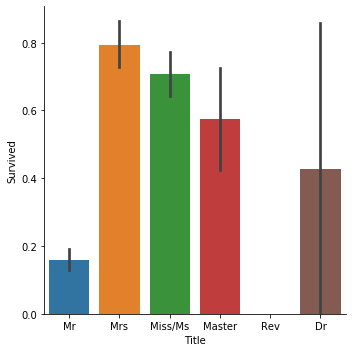

In [3]:
#Extracting Titles from Nameand mapping them to new values
X['Title']=X['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
X['Title'].replace(['Miss', 'Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Ms', inplace=True)
X['Title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer'], 'Mr', inplace=True)
sns.catplot(x='Title',y='Survived',data=X,kind='bar')

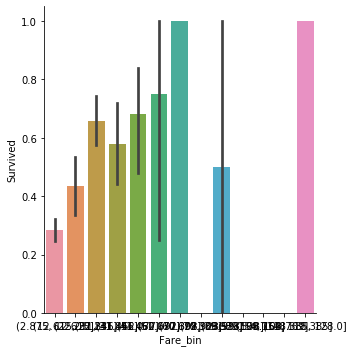

In [4]:
#Embarked
X['Embarked']=X['Embarked'].fillna('S')

#Fare
def rem_fare(r):
    if r.Fare==0:
        r.Fare=np.NaN
    return r    
X=X.apply(rem_fare,axis=1)        
X['Ticket_Freq'] = X.groupby('Ticket')['Ticket'].transform('count')
def fare(r):
    return r.Fare//r.Ticket_Freq
X['Fare_bin']=X.apply(fare,axis=1)
X['Fare_bin']=X['Fare_bin'].fillna(X['Fare_bin'].median())
X['Fare_bin']=pd.cut(X['Fare_bin'],13)
sns.catplot(x='Fare_bin',y='Survived',data=X,kind='bar')

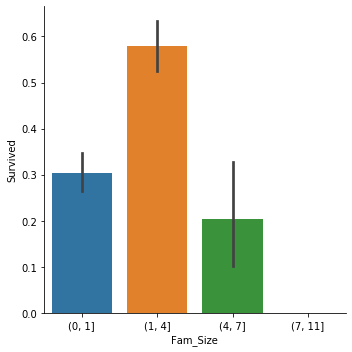

In [5]:
#Family Size
X['Fam_Size'] = X['SibSp'] + X['Parch'] + 1
X['Fam_Size']=pd.cut(X['Fam_Size'],[0,1,4,7,11])
sns.catplot(x='Fam_Size',y='Survived',data=X,kind='bar')

In [6]:
#Encoding 
X['Fam_Size']=LabelEncoder().fit_transform(X['Fam_Size'])
X['Fare_bin']=LabelEncoder().fit_transform(X['Fare_bin'])

encoded_features = []
cat_features = ['Pclass','Embarked', 'Title', 'Fam_Size','Fare_bin']
for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(X[feature].values.reshape(-1, 1)).toarray()
        n = X[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = X.index
        encoded_features.append(encoded_df)
    

X=pd.concat([X,*encoded_features[:]], axis=1)

In [7]:
#Dropping useless values
X=X.drop(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Title', 'Ticket_Freq', 'Fare_bin',
       'Fam_Size'],axis=1)
X.columns

Index(['Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_1', 'Embarked_2',
       'Embarked_3', 'Title_1', 'Title_2', 'Title_3', 'Title_4', 'Title_5',
       'Title_6', 'Fam_Size_1', 'Fam_Size_2', 'Fam_Size_3', 'Fam_Size_4',
       'Fare_bin_1', 'Fare_bin_2', 'Fare_bin_3', 'Fare_bin_4', 'Fare_bin_5',
       'Fare_bin_6', 'Fare_bin_7', 'Fare_bin_8', 'Fare_bin_9'],
      dtype='object')

In [8]:
train=X[:891]
test=X[891:]
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=.2, random_state=42)

In [9]:
#Using a Simple Logistic Regression model as problem isnt quite complex enough.
model=LogisticRegression()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

In [10]:
accuracy_score(y_pred,y_test) #Testing the model on unseen data

0.8212290502793296

In [11]:
cross_val_score(model,train,y,cv=6) #Cross Validation Scores

array([0.81879195, 0.79865772, 0.85234899, 0.81081081, 0.81081081,
       0.85810811])

In [12]:
#Training the model on the entire data to make final predictions
model.fit(train,y)
result=model.predict(test)

In [13]:
res=pd.read_csv('data/gender_submission.csv',index_col=None)
res['Survived']=result
res.to_csv('Submission.csv',index=False)